# Transfer Learning

Using the high level transfer learning APIs, you can easily customize pretrained models for feature extraction or fine-tuning. 

In this notebook, we will use a pre-trained Inception_V1 model. But we will operate on the pre-trained model to freeze first few layers, replace the classifier on the top, then fine tune the whole model. And we use the fine-tuned model to solve the dogs-vs-cats classification problem,

## Preparation

### 1. Get the dogs-vs-cats datasets

Download the training dataset from https://www.kaggle.com/c/dogs-vs-cats and extract it. 

The following commands copy about 1100 images of cats and dogs into demo/cats and demo/dogs separately. 
```shell
mkdir -p demo/dogs
mkdir -p demo/cats
cp train/cat.7* demo/cats
cp train/dog.7* demo/dogs```

### 2. Get the pre-trained Inception-V1 model

Download the pre-trained Inception-V1 model from [Zoo](https://s3-ap-southeast-1.amazonaws.com/bigdl-models/imageclassification/imagenet/bigdl_inception-v1_imagenet_0.4.0.model) 
 Alternatively, user may also download pre-trained caffe/Tensorflow/keras model.

In [2]:
import re

from bigdl.nn.criterion import CrossEntropyCriterion
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, StringType

from zoo.common.nncontext import *
from zoo.feature.image import *
from zoo.pipeline.api.keras.layers import Dense, Input, Flatten
from zoo.pipeline.api.keras.models import *
from zoo.pipeline.api.net import *
from zoo.pipeline.nnframes import *

In [3]:
sc = init_nncontext("ImageTransferLearningExample")

manually set model_path and image_path for training

1. model_path = path to the pre-trained models. (E.g. path/to/model/bigdl_inception-v1_imagenet_0.4.0.model)

2. image_path = path to the folder of the training images. (E.g. path/to/data/dogs-vs-cats/demo/\*/\*)

In [5]:
model_path = "/opt/work/bigdl_inception-v1_imagenet_0.4.0.model"
image_path = "file:///opt/work/demo/*/*"
imageDF = NNImageReader.readImages(image_path, sc)

In [7]:
getName = udf(lambda row:
                  re.search(r'(cat|dog)\.([\d]*)\.jpg', row[0], re.IGNORECASE).group(0),
                  StringType())
getLabel = udf(lambda name: 1.0 if name.startswith('cat') else 2.0, DoubleType())

labelDF = imageDF.withColumn("name", getName(col("image"))) \
        .withColumn("label", getLabel(col('name')))
(trainingDF, validationDF) = labelDF.randomSplit([0.9, 0.1])
labelDF.select("name","label").show(10)

+------------+-----+
|        name|label|
+------------+-----+
|cat.7859.jpg|  1.0|
|cat.7307.jpg|  1.0|
|cat.7156.jpg|  1.0|
|cat.7718.jpg|  1.0|
|cat.7519.jpg|  1.0|
|cat.7397.jpg|  1.0|
|cat.7134.jpg|  1.0|
|cat.7841.jpg|  1.0|
|cat.7669.jpg|  1.0|
|cat.7518.jpg|  1.0|
+------------+-----+
only showing top 10 rows



## Fine-tune a pre-trained model

We fine-tune a pre-trained model by removing the last few layers, freezing the first few layers, and adding some new layers.

In [8]:
transformer = ChainedPreprocessing(
        [RowToImageFeature(), ImageResize(256, 256), ImageCenterCrop(224, 224),
         ImageChannelNormalize(123.0, 117.0, 104.0), ImageMatToTensor(), ImageFeatureToTensor()])

creating: createRowToImageFeature
creating: createImageResize
creating: createImageCenterCrop
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing


### Load a pre-trained model

We use the Net API to load a pre-trained model, including models saved by Analytics Zoo, BigDL, Torch, Caffe and Tensorflow. Please refer to [Net API Guide](https://analytics-zoo.github.io/master/#APIGuide/PipelineAPI/net/).

In [ ]:
full_model = Net.load_bigdl(model_path)

### Remove the last few layers

Here we print all the model layers and you can choose which layer(s) to remove.

When a model is loaded using Net, we can use the newGraph(output) api to define a Model with the output specified by the parameter. 

In [25]:
for layer in full_model.layers:
    print (layer.name())
model = full_model.new_graph(["pool5/drop_7x7_s1"])

data
conv1/7x7_s2
conv1/relu_7x7
pool1/3x3_s2
pool1/norm1
conv2/3x3_reduce
conv2/relu_3x3_reduce
conv2/3x3
conv2/relu_3x3
conv2/norm2
pool2/3x3_s2
inception_3a/3x3_reduce
inception_3a/5x5_reduce
inception_3a/relu_3x3_reduce
inception_3a/relu_5x5_reduce
inception_3a/pool
inception_3a/1x1
inception_3a/3x3
inception_3a/5x5
inception_3a/pool_proj
inception_3a/relu_pool_proj
inception_3a/relu_5x5
inception_3a/relu_3x3
inception_3a/relu_1x1
inception_3a/output
inception_3b/3x3_reduce
inception_3b/5x5_reduce
inception_3b/relu_3x3_reduce
inception_3b/relu_5x5_reduce
inception_3b/pool
inception_3b/1x1
inception_3b/3x3
inception_3b/5x5
inception_3b/pool_proj
inception_3b/relu_pool_proj
inception_3b/relu_5x5
inception_3b/relu_3x3
inception_3b/relu_1x1
inception_3b/output
pool3/3x3_s2
inception_4a/3x3_reduce
inception_4a/5x5_reduce
inception_4a/relu_3x3_reduce
inception_4a/relu_5x5_reduce
inception_4a/pool
inception_4a/1x1
inception_4a/3x3
inception_4a/5x5
inception_4a/pool_proj
inception_4a/relu_

The returning model's output layer is "pool5/drop_7x7_s1".

### Freeze some layers

We freeze layers from input to pool4/3x3_s2 inclusive.

In [26]:
model.freeze_up_to(["pool4/3x3_s2"])

### Add a few new layers

In [27]:
inputNode = Input(name="input", shape=(3, 224, 224))
inception = model.to_keras()(inputNode)
flatten = Flatten()(inception)
logits = Dense(2)(flatten)
lrModel = Model(inputNode, logits)
classifier = NNClassifier(lrModel, CrossEntropyCriterion(), transformer) \
        .setLearningRate(0.003).setBatchSize(40).setMaxEpoch(1).setFeaturesCol("image") \
        .setCachingSample(False)
pipeline = Pipeline(stages=[classifier])

creating: createZooKerasInput
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasModel
creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier


# Train the model

The transfer learning can finish in a few minutes. 

In [30]:
catdogModel = pipeline.fit(trainingDF)
predictionDF = catdogModel.transform(validationDF).cache()

creating: createToTuple
creating: createChainedPreprocessing


In [31]:
predictionDF.select("name","label","prediction").sort("label", ascending=False).show(10)
predictionDF.select("name","label","prediction").show(10)
correct = predictionDF.filter("label=prediction").count()
overall = predictionDF.count()
accuracy = correct * 1.0 / overall
print("Test Error = %g " % (1.0 - accuracy))

+------------+-----+----------+
|        name|label|prediction|
+------------+-----+----------+
|dog.7000.jpg|  2.0|       2.0|
|dog.7062.jpg|  2.0|       2.0|
|dog.7004.jpg|  2.0|       2.0|
|dog.7007.jpg|  2.0|       2.0|
|dog.7012.jpg|  2.0|       2.0|
|dog.7024.jpg|  2.0|       2.0|
|dog.7027.jpg|  2.0|       2.0|
|dog.7031.jpg|  2.0|       2.0|
|dog.7033.jpg|  2.0|       2.0|
| dog.704.jpg|  2.0|       2.0|
+------------+-----+----------+
only showing top 10 rows

+------------+-----+----------+
|        name|label|prediction|
+------------+-----+----------+
|cat.7026.jpg|  1.0|       1.0|
|cat.7027.jpg|  1.0|       1.0|
|cat.7048.jpg|  1.0|       1.0|
|cat.7059.jpg|  1.0|       1.0|
|cat.7061.jpg|  1.0|       1.0|
|cat.7064.jpg|  1.0|       1.0|
|cat.7077.jpg|  1.0|       1.0|
|cat.7097.jpg|  1.0|       1.0|
|cat.7098.jpg|  1.0|       1.0|
|cat.7106.jpg|  1.0|       1.0|
+------------+-----+----------+
only showing top 10 rows

Test Error = 0.0287081 


As we can see, the model from transfer learning can achieve over 95% accuracy on the validation set.

## Visualize result

We randomly select some images to show, and print the prediction results here. 

cat: prediction = 1.0
dog: prediction = 2.0

In [32]:
samplecat=predictionDF.filter(predictionDF.prediction==1.0).limit(3).collect()
sampledog=predictionDF.filter(predictionDF.prediction==2.0).sort("label", ascending=False).limit(3).collect()

prediction:


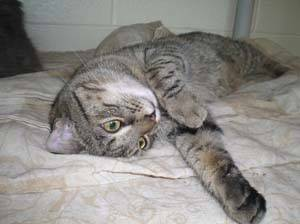

prediction:


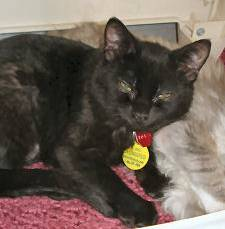

prediction:


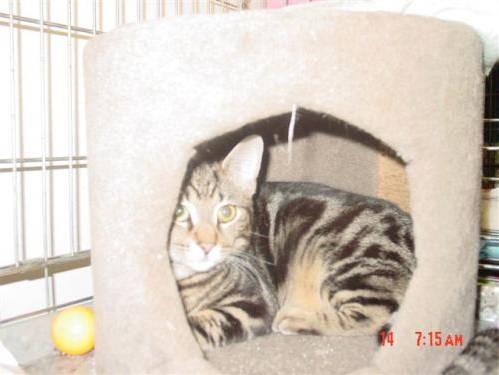

In [33]:
from IPython.display import Image, display
for cat in samplecat:
    print ("prediction:"), cat.prediction
    display(Image(cat.image.origin[5:]))

prediction:


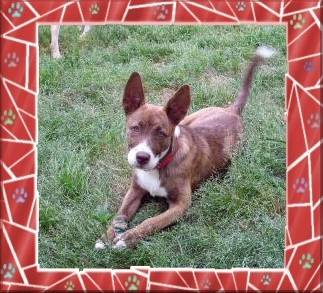

prediction:


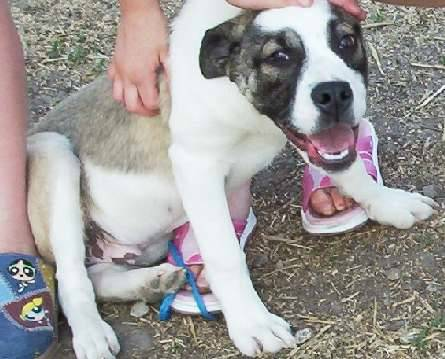

prediction:


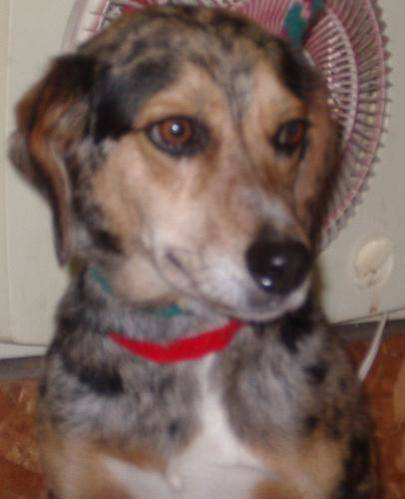

In [34]:
for dog in sampledog:
    print ("prediction:"), dog.prediction
    display(Image(dog.image.origin[5:]))